#### Copyright © 2023 Taeyoung Kim and Mingi Kang. All rights reserved. ####

This is the solution for the homework assignment of the Machine Learning and Optimization lecture for WS2023. 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

#### Part 1

In [2]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # First convolutional layer
        self.pool = nn.MaxPool2d(2, 2)   # Max pooling
        self.conv2 = nn.Conv2d(6, 16, 5) # Second convolutional layer
       
    
        self.fc1_size = 16 * 5 * 5       # based on the tensor size
        
        self.fc1 = nn.Linear(self.fc1_size, 120)  # First fully connected layer
        self.fc2 = nn.Linear(120, 84)    # Second fully connected layer
        self.fc3 = nn.Linear(84, num_classes) # Final fully connected layer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.fc1_size)    # flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### Part 2 CNN using shuffle data

In [3]:
def shuffle_pixels(images):
    batch_size, channels, height, width = images.shape
    total_pixels = channels * height * width

    # Generate a random permutation
    permutation = torch.randperm(total_pixels)

    # reshaep, apply permutation and reshape again
    shuffled = images.view(batch_size, total_pixels)[:, permutation]
    shuffled = shuffled.view(batch_size, channels, height, width)
    return shuffled

### (Part 2) Expected Outcome: 
The performance should significantly decrease compared to the original dataset because shuffling of pixels disrupts the spatial relationships that CNNs leverage to detect patterns and feature.

### (Part 3) Expected Outcome: 
The performance of the F- CNN willnot degrade as much as the CNN's on the shuffled dataset. This is because FCNNs do not rely on the spatial arrangement of pixels, treating the input as a flat vector.

## Learning Example

In [4]:
# Load CIFAR-10 Data
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Initialize
net = SimpleCNN(num_classes=3)

In [6]:
# Dummy Training Loop
### replace with actual training code

for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    inputs = shuffle_pixels(inputs)  # Shuffle pixels for Part 2 and Part 3
    
    
    if i == 1: # break early
        break


In [7]:
def test_model(model, testloader, device):
    model.eval() 
    correct = 0
    total = 0
    
    
    with torch.no_grad(): 
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the network on the test images: {accuracy}%')
    return accuracy

In [8]:
#pip install --upgrade torch torchvision


In [9]:
# define the device
device = torch.device("cpu")
net.to(device)

SimpleCNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)

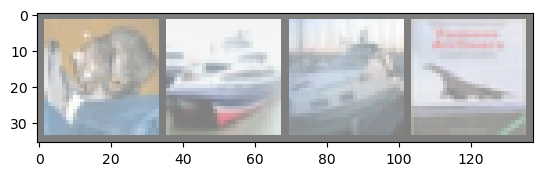

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Function for img
def imshow(img):
    img = img / 2 + 0.5     # not normalised
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    

# Get random test img
dataiter = iter(testloader)
images, labels =  next(dataiter)

# Show img
imshow(torchvision.utils.make_grid(images))



In [11]:
# For adjusting visualizing
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)
predicted = predicted.to("cpu")  # Move predictions back to CPU


In [12]:
# # img, cpu, device error solving 

# images = images.to(device)
# outputs = net(images)
# _, predicted = torch.max(outputs, 1)
# predicted = predicted.to("cpu")

In [13]:


#### RESULTS #####

# Print labels
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]}' for j in range(4)))

# Predict labels
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]}' for j in range(4)))


GroundTruth:  cat ship ship plane
Predicted:  plane plane plane plane


### Updates the model

In [14]:
# Define the classes that we interested in
selected_classes = ['cat', 'dog', 'ship']

# Filtering
trainset.targets = [selected_classes.index(trainset.classes[target]) if trainset.classes[target] in selected_classes else -1 for target in trainset.targets]
trainset.data = trainset.data[np.array(trainset.targets) != -1]
trainset.targets = [target for target in trainset.targets if target != -1]

testset.targets = [selected_classes.index(testset.classes[target]) if testset.classes[target] in selected_classes else -1 for target in testset.targets]
testset.data = testset.data[np.array(testset.targets) != -1]
testset.targets = [target for target in testset.targets if target != -1]

In [15]:
import torch.optim as optim

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Epochs number
num_epochs = 10 # for example

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the param. gradients
        optimizer.zero_grad()

        # forwarding pass
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        # backwarding pass
        loss.backward()
        
        # optimize
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:  # Print every 2000 mini batches
            print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')


[1, 2000] loss: 1.015
[2, 2000] loss: 0.702
[3, 2000] loss: 0.624
[4, 2000] loss: 0.587
[5, 2000] loss: 0.559
[6, 2000] loss: 0.521
[7, 2000] loss: 0.511
[8, 2000] loss: 0.483
[9, 2000] loss: 0.468
[10, 2000] loss: 0.428
Finished Training


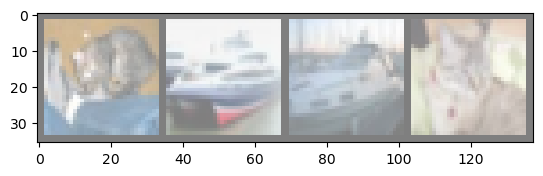

GroundTruth:  plane bird bird plane
Predicted:  plane bird bird car


In [18]:
# Get random test img
dataiter = iter(testloader)
images, labels = next(dataiter)

# Show img
imshow(torchvision.utils.make_grid(images))

# Print GroundTruth and Predicted label
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]}' for j in range(4)))
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)
predicted = predicted.to("cpu")
print('Predicted: ', ' '.join(f'{classes[predicted[j]]}' for j in range(4)))
